In [14]:
# Install PyTorch & dependencies (Colab usually already has it)
!pip install torch torchvision torchaudio --quiet
!pip install seaborn --quiet

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cuda


In [15]:
# Transform: Resize to 224x224 for ResNet/VGG, Normalize for pretrained models
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 (downloads automatically)
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Select only 3 classes: 0=airplane, 1=automobile, 2=bird
selected_classes = [0, 1, 2]
train_idx = [i for i, (_, label) in enumerate(train_data) if label in selected_classes]
test_idx = [i for i, (_, label) in enumerate(test_data) if label in selected_classes]

train_data = Subset(train_data, train_idx)
test_data = Subset(test_data, test_idx)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f" Train samples: {len(train_data)}, Test samples: {len(test_data)}")


 Train samples: 15000, Test samples: 3000


In [16]:
def train_model_with_graphs(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Test accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        test_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_losses[-1]:.4f}, Test Acc: {accuracy:.2f}%")

    # Plot curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(test_accuracies, label="Test Accuracy", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy Curve")
    plt.legend()

    plt.show()


Epoch [1/10] Loss: 0.2637, Test Acc: 89.40%
Epoch [2/10] Loss: 0.1744, Test Acc: 94.57%
Epoch [3/10] Loss: 0.1233, Test Acc: 95.47%
Epoch [4/10] Loss: 0.1077, Test Acc: 92.47%
Epoch [5/10] Loss: 0.0950, Test Acc: 95.67%
Epoch [6/10] Loss: 0.0633, Test Acc: 95.73%
Epoch [7/10] Loss: 0.0668, Test Acc: 96.00%
Epoch [8/10] Loss: 0.0476, Test Acc: 95.47%
Epoch [9/10] Loss: 0.0422, Test Acc: 95.97%
Epoch [10/10] Loss: 0.0481, Test Acc: 96.33%


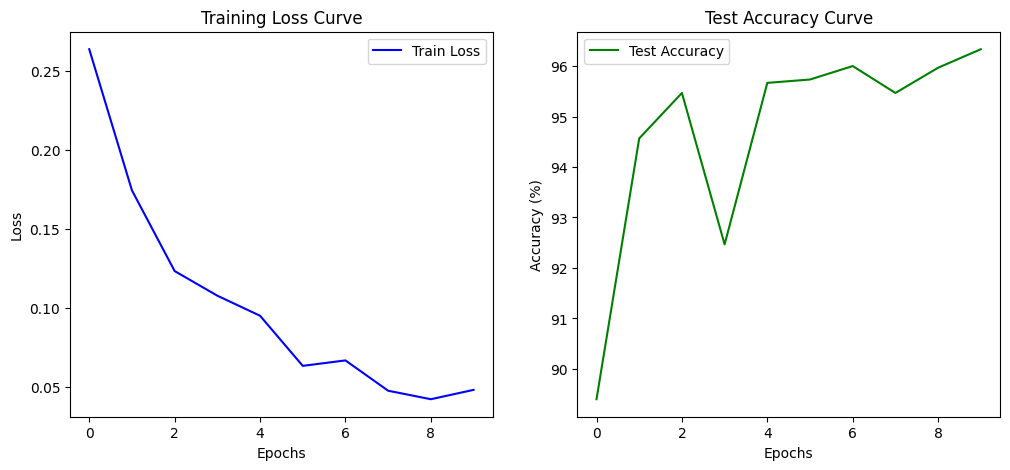

In [17]:
# Load ResNet-18
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 3)
resnet18 = resnet18.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Train
train_model_with_graphs(resnet18, train_loader, test_loader, criterion, optimizer, epochs=10)


In [18]:
def quick_fit_check(model, train_loader, test_loader):
    # Function to get accuracy
    def get_accuracy(loader):
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return 100 * correct / total

    train_acc = get_accuracy(train_loader)
    test_acc = get_accuracy(test_loader)

    print(f" Train Accuracy: {train_acc:.2f}%")
    print(f" Test Accuracy:  {test_acc:.2f}%")

    # Quick judgement
    if train_acc - test_acc > 10:
        print(" Likely Overfitting (big gap between train & test)")
    elif train_acc < 70 and test_acc < 70:
        print(" Likely Underfitting (both low)")
    else:
        print(" Looks balanced (no strong signs of over/underfitting)")

# Run the check for ResNet-18
quick_fit_check(resnet18, train_loader, test_loader)


 Train Accuracy: 99.33%
 Test Accuracy:  96.33%
 Looks balanced (no strong signs of over/underfitting)


Epoch [1/10] Loss: 0.8317, Test Acc: 80.90%
Epoch [2/10] Loss: 0.5205, Test Acc: 83.43%
Epoch [3/10] Loss: 0.4483, Test Acc: 85.50%
Epoch [4/10] Loss: 0.4112, Test Acc: 85.53%
Epoch [5/10] Loss: 0.3867, Test Acc: 85.27%
Epoch [6/10] Loss: 0.3364, Test Acc: 87.50%
Epoch [7/10] Loss: 0.3478, Test Acc: 87.37%
Epoch [8/10] Loss: 0.3187, Test Acc: 86.97%
Epoch [9/10] Loss: 0.3170, Test Acc: 84.83%
Epoch [10/10] Loss: 0.2993, Test Acc: 89.03%


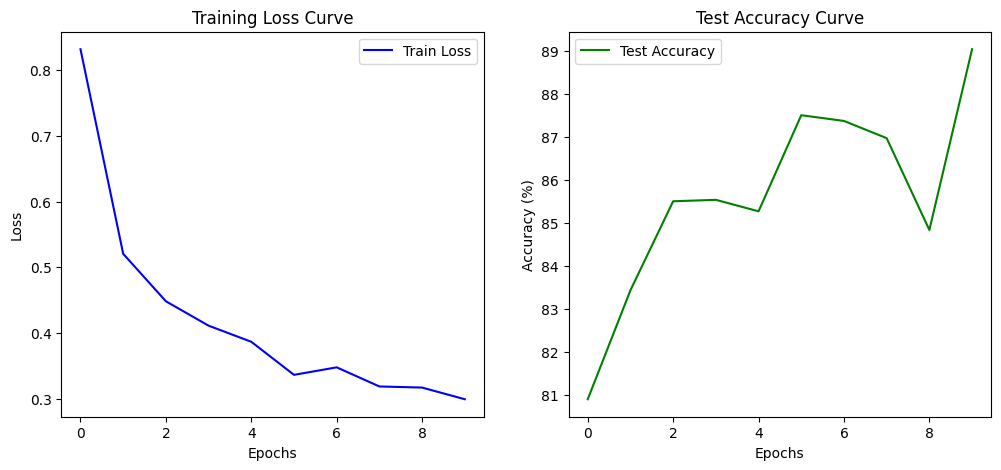

In [19]:
# Load VGG16
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 3)
vgg16 = vgg16.to(device)

# Loss & optimizer
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg16.parameters(), lr=0.001)

# Train
train_model_with_graphs(vgg16, train_loader, test_loader, criterion_vgg, optimizer_vgg, epochs=10)


In [20]:
# check for VGG16
quick_fit_check(vgg16, train_loader, test_loader)


 Train Accuracy: 91.32%
 Test Accuracy:  89.03%
 Looks balanced (no strong signs of over/underfitting)


🔹 ResNet-18 Evaluation:
 Test Accuracy: 96.33%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.97      0.93      0.95      1000
  automobile       0.99      0.99      0.99      1000
        bird       0.93      0.97      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



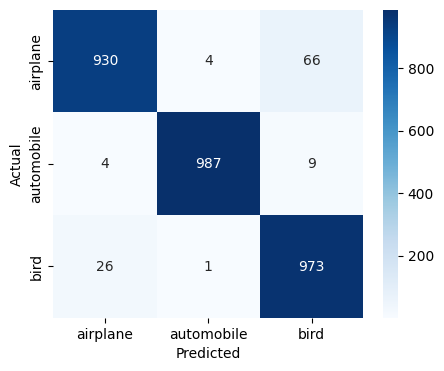

🔹 VGG16 Evaluation:
 Test Accuracy: 89.03%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.83      0.85      1000
  automobile       0.96      0.93      0.94      1000
        bird       0.84      0.91      0.88      1000

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



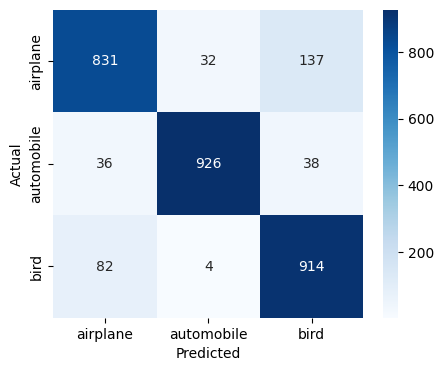

In [22]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f" Test Accuracy: {accuracy*100:.2f}%\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["airplane", "automobile", "bird"]))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["airplane", "automobile", "bird"],
                yticklabels=["airplane", "automobile", "bird"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate both models
print("🔹 ResNet-18 Evaluation:")
evaluate_model(resnet18, test_loader)

print("🔹 VGG16 Evaluation:")
evaluate_model(vgg16, test_loader)


Model Comparison:
ResNet-18 Accuracy: 96.33%
VGG16 Accuracy:    89.03%


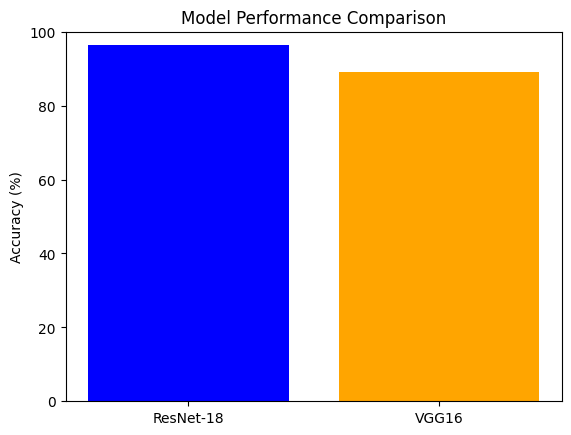

In [23]:
def get_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

resnet_acc = get_accuracy(resnet18, test_loader)
vgg_acc = get_accuracy(vgg16, test_loader)

print("Model Comparison:")
print(f"ResNet-18 Accuracy: {resnet_acc:.2f}%")
print(f"VGG16 Accuracy:    {vgg_acc:.2f}%")

plt.bar(["ResNet-18", "VGG16"], [resnet_acc, vgg_acc], color=["blue", "orange"])
plt.ylabel("Accuracy (%)")
plt.title("Model Performance Comparison")
plt.ylim(0, 100)
plt.show()
